In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3, batman
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

In [2]:
fnames = ascii.read('filenames.csv')
len(fnames)

396

In [3]:
img_list = []
hdr_list = []
for fn in fnames:
    hdu = fits.open(fn[0])
    header = hdu[0].header
    if header['OBSTYPE'] == 'SPECTROSCOPIC':
        image = hdu[1].data
        img_list.append(image)
        hdr_list.append(header)
    hdu.close()
len(img_list)

392

In [4]:
data = ascii.read('lc_info.csv')

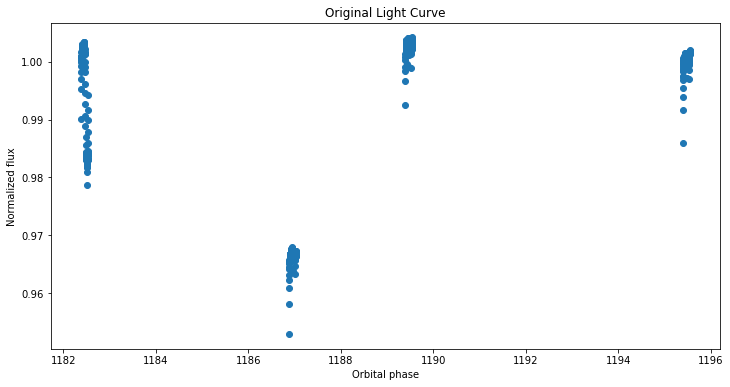

In [5]:
tt        = 2454159.45320
period    = 1.5089557
jd_const  = 2400000.5
norm_flux = data['res_flux']/np.median(data['res_flux'])
op        = np.sort((data['time'] + jd_const - tt)/period)
ind       = np.argsort(data['time'])

fig, ax = plt.subplots()
points = ax.plot(op, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Original Light Curve')

# fig.savefig('Light_Curve.pdf')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['{}, {}'.format(i + 1, pa) for i, pa in zip(range(len(op)), data['position angle'][ind])]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
plugins.connect(fig, tooltip)

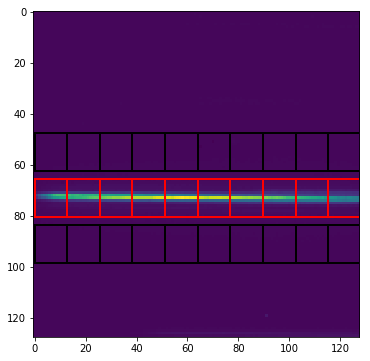

In [6]:
plt.imshow(img_list[10])

y_levels = [73, 91, 55]
width    = 128/10.
start    = 0
while (start < (128-width)):
    for y in y_levels:
        x = start + (width/2.)  
        aper = RectangularAperture((x, y), w = width, h = 15, theta = 0.0)
        if y==73 :
            aper.plot(color = 'r', linewidth = 2)
        else:
            aper.plot(color = 'k', linewidth = 2)
    start += width

In [7]:
y1, y2, y3 = [73, 91, 55]  #spectrum, upper bg, lower bg
width      = 128/10.
flux_array = np.zeros([392, 10]) #392 images, 10 boxes each

for i, (image, header) in enumerate(zip(img_list, hdr_list)):
    
    mask    = np.isnan(image) == True
    counter = 0
    start   = 0
    
    while (start < (128-width)):     #iterating over every box
        x      = start + (width/2.)
        src_ap = RectangularAperture((x, y1), w = width, h = 15, theta = 0.0)
        bk_ap1 = RectangularAperture((x, y2), w = width, h = 15, theta = 0.0)
        bk_ap2 = RectangularAperture((x, y3), w = width, h = 15, theta = 0.0)
    
        raw = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
        
        bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
        bkg_mean1 = bkg1/bk_ap1.area()
        bkg_flux1 = bkg_mean1*src_ap.area()
        
        bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
        bkg_mean2 = bkg2/bk_ap2.area()
        bkg_flux2 = bkg_mean2*src_ap.area()
        
        bkg = (bkg_flux1 + bkg_flux2)/2
        res = raw - bkg
        
        flux_array[i][counter] = res
        
        start    += width
        counter  += 1

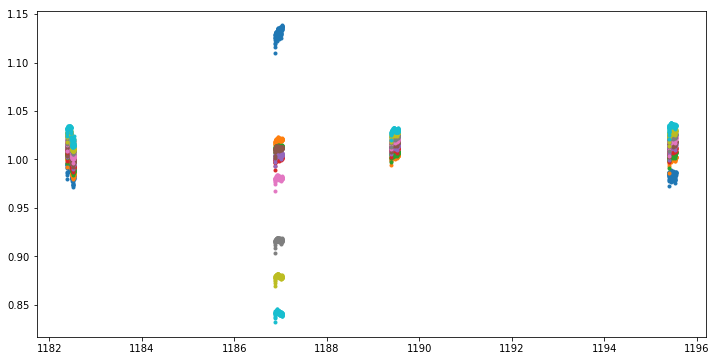

In [8]:
for i in range(10):
    flux = []
    for j in range(392):
        flux.append(flux_array[j][i]) # flux_array[image index][box number]
    plt.plot(op, (flux/np.median(flux))+(i/300), '.')

# Applying exponential model to 10 boxes

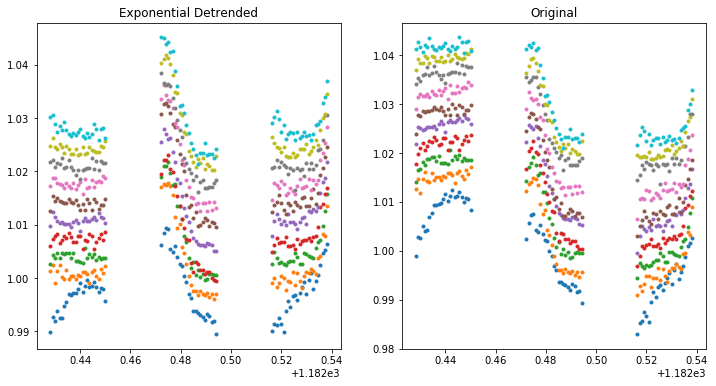

In [9]:
# defining exponential function for visit 1, orbit 2
op12        = op[23:48]
flux12      = norm_flux[23:48]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op12-op12[0], flux12, p0=(1, (1.5*24*60)/10, 0))

plt.subplot(121)
for i in range(10):
    
    # normalized fluxes
    n_v1o2 = flux_array[23:48,i]/np.median(flux_array[23:48,i])
    n_v1o3 = flux_array[48:73,i]/np.median(flux_array[48:73,i])
    n_v1o4 = flux_array[73:98,i]/np.median(flux_array[73:98,i])
    
    #detrended fluxes
    f_v1o2 = n_v1o2/f(op[23:48] - op[23], *param)
    f_v1o3 = n_v1o3/f(op[48:73] - op[48], *param)
    f_v1o4 = n_v1o4/f(op[73:98] - op[73], *param)
    
    flux = np.concatenate((f_v1o2,f_v1o3,f_v1o4))
    plt.plot(op[23:98], flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(23,98):
        flux.append(flux_array[j][i])
    plt.plot(op[23:98], (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

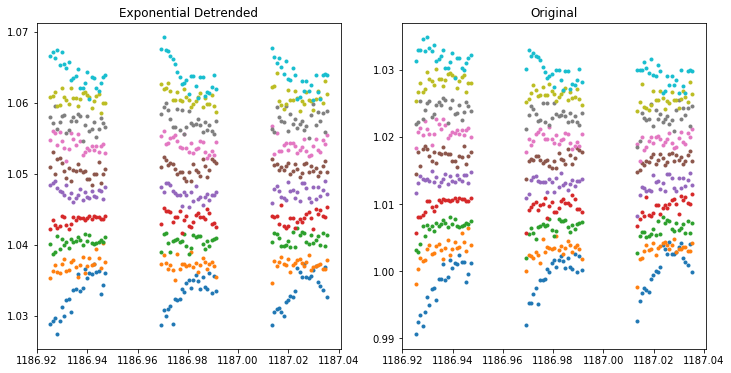

In [11]:
# defining exponential function for visit 2, orbit 2
op22        = op[121:146]
flux22      = norm_flux[121:146]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val

param, _ = curve_fit(f, op22-op22[0], flux22, p0=(1, (1.5*24*60)/10, 0))

plt.subplot(121)
for i in range(10):
    
    # normalized fluxes
    n_v2o2 = flux_array[121:146,i]/np.median(flux_array[121:146,i])
    n_v2o3 = flux_array[146:171,i]/np.median(flux_array[146:171,i])
    n_v2o4 = flux_array[171:196,i]/np.median(flux_array[171:196,i])
    
    #detrended fluxes
    f_v2o2 = n_v2o2/f(op[121:146] - op[121], *param)
    f_v2o3 = n_v2o3/f(op[146:171] - op[146], *param)
    f_v2o4 = n_v2o4/f(op[171:196] - op[171], *param)
    
    flux = np.concatenate((f_v2o2,f_v2o3,f_v2o4))
    plt.plot(op[121:196], flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(121, 196):
        flux.append(flux_array[j][i])
    plt.plot(op[121:196], (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

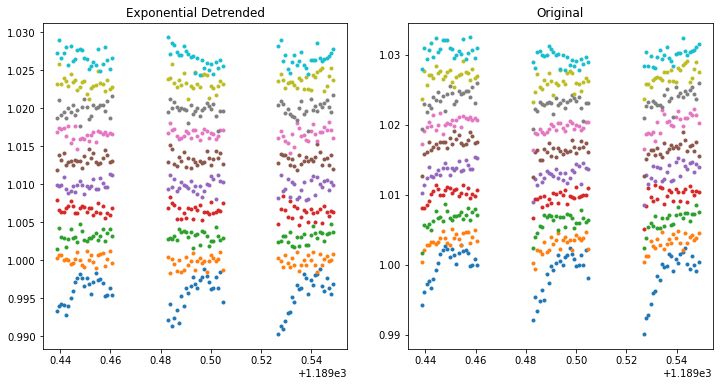

In [15]:
# defining exponential function for visit 3, orbit 2
op32        = op[219:244]
flux32      = norm_flux[219:244]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op32-op32[0], flux32, p0=(1, (1.5*24*60)/10, 0))

plt.subplot(121)
for i in range(10):
    
    # normalized fluxes
    n_v3o2 = flux_array[219:244,i]/np.median(flux_array[219:244,i])
    n_v3o3 = flux_array[244:269,i]/np.median(flux_array[244:269,i])
    n_v3o4 = flux_array[269:294,i]/np.median(flux_array[269:294,i])
    
    #detrended fluxes
    f_v3o2 = n_v3o2/f(op[219:244] - op[219], *param)
    f_v3o3 = n_v3o3/f(op[244:269] - op[244], *param)
    f_v3o4 = n_v3o4/f(op[269:294] - op[269], *param)
    
    flux = np.concatenate((f_v3o2,f_v3o3,f_v3o4))
    plt.plot(op[219:294], flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(219, 294):
        flux.append(flux_array[j][i])
    plt.plot(op[219:294], (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

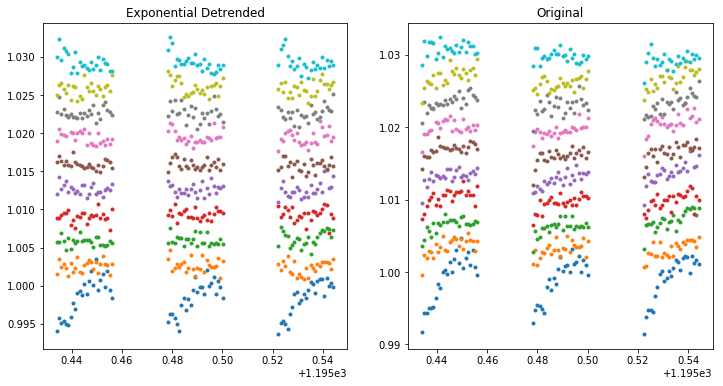

In [16]:
# defining exponential function for visit 4, orbit 2
op42        = op[317:342]
flux42      = norm_flux[317:342]
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op42-op42[0], flux42, p0=(1, (1.5*24*60)/10, 0))

plt.subplot(121)
for i in range(10):
    
    # normalized fluxes
    n_v4o2 = flux_array[317:342,i]/np.median(flux_array[317:342,i])
    n_v4o3 = flux_array[342:367,i]/np.median(flux_array[342:367,i])
    n_v4o4 = flux_array[367:392,i]/np.median(flux_array[367:392,i])
    
    #detrended fluxes
    f_v4o2 = n_v4o2/f(op[317:342] - op[317], *param)
    f_v4o3 = n_v4o3/f(op[342:367] - op[342], *param)
    f_v4o4 = n_v4o4/f(op[367:392] - op[367], *param)
    
    flux = np.concatenate((f_v4o2,f_v4o3,f_v4o4))
    plt.plot(op[317:392], flux+(i/300), '.')
    plt.title('Exponential Detrended')

plt.subplot(122)
for i in range(10):
    flux = []
    for j in range(317,392):
        flux.append(flux_array[j][i])
    plt.plot(op[317:392], (flux/np.median(flux))+(i/300), '.')
    plt.title('Original')

# Fitting batman model to cleaner transit light curve

In [ ]:
def f(x, a, b, c):
    val = a*(1 - np.exp(-b*(x+c)))
    return val
param, _ = curve_fit(f, op12-op12[0], flux12, p0=(1, (1.5*24*60)/10, 0))

